##### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2025 Semester 1

## Assignment 1: Scam detection with Naive Bayes


**Student ID(s):**     1462539


## 0. Set-up

First, we import all the necessary libraries and load the labeled training data from `sms_supervised_train.csv`.

In [167]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from typing import List, Set, Dict, Tuple

labelled_train = pd.read_csv('data/sms_supervised_train.csv')

Now that we have loaded our training dataset, let us delete rows where `textPreprocessed` is empty by calling `data.dropna`. These instances do not have any meaningful features we can learn from. After cleaning, we can then tokenise (split) the already preprossessd text for our next stage.

In [168]:
labelled_train.dropna(subset=['textPreprocessed'], inplace=True)
labelled_train['tokens'] = labelled_train['textPreprocessed'].apply(lambda x: x.split())

Let us define the **vocabulary**, which is a set of every word which occurs in the training data set

In [169]:
vocabulary = set()
for tokens in labelled_train['tokens']:
    vocabulary.update(tokens)
vocab_list = list(vocabulary)

Define **count** matrix (Bag-of-Words feature matrix). Since the dataset is already preprocessed, I am directly supplying `vocabulary` to `CountVectorizer` without calling `fit()`, to avoid any unintended token filtering. Note that we are going to follow the convention where $X$ represents the input features and $y$ represents the target labels; this notation is used consistently throughout the notebook.

In [170]:
vectorizer: CountVectorizer = CountVectorizer(vocabulary=vocab_list)
X: np.ndarray = vectorizer.transform(labelled_train['textPreprocessed'])
y: np.ndarray = labelled_train['class'].values

## 1. Supervised model training


### 1.1 Prior Probabilities

We are now ready to compute the prior probability of each class, $P(C)$. The result is returned as a dictionary mapping each class label to its corresponding prior probability: ${C : P(C)}$.

In [171]:
def calc_prior(data: pd.DataFrame, label_col: str = 'class') -> Dict[int, float]:
    class_counts = data[label_col].value_counts()
    total = class_counts.sum()
    return (class_counts / total).to_dict()

priors = calc_prior(labelled_train)

### 1.2 Most Probable Words

The next set of probabilities we need to calculate are the conditional probabilities, which represent the likelihood of each feature value given a specific class label. Recall that our "count" matrix encodes how many times each word appears in a message. For example:

```
message1: [1, 0, 2] → "call now now"
message2: [0, 1, 1] → "win now"
```

To compute the **total word counts per class**, we sum the corresponding vectors:

```
[1 + 0, 0 + 1, 2 + 1] = [1, 1, 3]
```

Each entry in this resulting vector, `word_counts[i]`, corresponds to exactly $\text{count}_{c,i}$. where

$$
P(w_i \mid c) = \frac{\text{count}_{c,i} + \alpha}{\text{total}_c + V \alpha}.
$$

In [178]:
def calc_likelihood(X: np.ndarray, y: np.ndarray, alpha: float = 1.0) -> Dict[int, np.ndarray]:
    classes = np.unique(y)
    vocab_size = X.shape[1]
    likelihoods = {}

    for c in classes:
        X_c = X[y == c]                                 # rows for class c (y == c) is a mask
        word_counts = X_c.sum(axis=0)                   # sum over rows → word frequency vector
        word_counts = np.asarray(word_counts).flatten() # convert to 1D array
        total_count = word_counts.sum()
        likelihoods[c] = (word_counts + alpha) / (total_count + alpha * vocab_size)

    return likelihoods

likelihoods = calc_likelihood(X, y)

Let us now identify the most probable words in each class. Class $0$ represents non-malicious messages, while Class $1$ corresponds to scam messages.

In [182]:
def get_top_words(likelihood, vocab, class_label, top_n=10):
    indices = np.argsort(-likelihood[class_label])[:top_n] # - for descending order
    return [(vocab[i], likelihood[class_label][i]) for i in indices]

top_words_0 = get_top_words(likelihoods, vocab_list, 0)
top_words_1 = get_top_words(likelihoods, vocab_list, 1)

# print("Top 10 most probable words in non-malicious class:")
# for word, prob in top_words_0:
#     print(f"{word}: {prob:.4f}")

# print("\nTop 10 most probable words in scam class:")
# for word, prob in top_words_1:
#     print(f"{word}: {prob:.4f}")

### 1.3 Most Predictive Words

Let us now get words that are most strongly predictive of each class. We can do this by computing the likelihood ratio,

$$
\text{Predictiveness} = \frac{P(w \mid \text{scam})}{P(w \mid \text{non-malicious})}.
$$

The ratio tells us **which words appear much more often in one class than the other**.

In [ ]:
def get_predictive_words(likelihoods, vocab, top_n=10):
    ratio_1_over_0 = likelihoods[1] / likelihoods[0]
    ratio_0_over_1 = likelihoods[0] / likelihoods[1]
    top_1_indices = np.argsort(-ratio_1_over_0)[:top_n]
    top_0_indices = np.argsort(-ratio_0_over_1)[:top_n]
    top_scams = [(vocab[i], ratio_1_over_0[i]) for i in top_1_indices]
    top_nonmal = [(vocab[i], ratio_0_over_1[i]) for i in top_0_indices]
    return top_scams, top_nonmal

top_predictive_1, top_predictive_0 = get_predictive_words(likelihoods, vocab_list)

# print("Top 10 most predictive words for scam class (P(w|1) / P(w|0)):")
# for word, ratio in top_predictive_1:
#     print(f"{word}: {ratio:.2f}")

# print("\nTop 10 most predictive words for non-malicious class (P(w|0) / P(w|1)):")
# for word, ratio in top_predictive_0:
#     print(f"{word}: {ratio:.2f}")

Top 10 most predictive words for scam class (P(w|1) / P(w|0)):
prize: 88.80
tone: 57.46
select: 41.79
claim: 41.21
50: 34.82
paytm: 33.08
code: 31.34
award: 28.73
won: 27.86
18: 26.12

Top 10 most predictive words for non-malicious class (P(w|0) / P(w|1)):
gt: 60.30
lt: 59.73
lor: 32.16
hope: 27.57
ok: 27.57
da: 22.40
let: 20.10
wat: 19.53
oh: 18.38
lol: 17.80


## 2. Supervised model evaluation

$$P(c \mid count) \propto P(c)P(count \mid c)$$
$$\log{P(c \mid doc)} \propto \log{P(c)} + \sum_{i}{x_i \cdot \log{P(w_i \mid c)}}$$

In [119]:
def calc_posterior(counts: np.ndarray, priors: Dict[int, float], likelihoods: Dict[int, np.ndarray]) -> Dict[int, float]:
    """Calculate log-posterior score for each class"""
    scores = {}
    for c in priors:
        log_prior = np.log(priors[c])
        log_likelihood = np.log(likelihoods[c])
        scores[c] = log_prior + np.dot(counts, log_likelihood)
    return scores

In [120]:
def predict_batch(texts: List[str], priors: Dict[int, float], likelihoods: Dict[int, np.ndarray], 
                  vectorizer: CountVectorizer) -> Tuple[np.ndarray, np.ndarray]:
    predictions: List[int] = []
    confidence_ratios: List[float] = []

    for text in texts:
        # Transform the text into a count vector
        counts: np.ndarray = vectorizer.transform([text]).toarray().flatten()
        # Calculate posterior scores for each class
        scores: Dict[int, float] = calc_posterior(counts, priors, likelihoods)
        # Append the predicted class (class with the highest posterior score)
        predictions.append(max(scores, key=scores.get))
        # Append the confidence ratio (P(class 1) / P(class 0))
        confidence_ratios.append(np.exp(scores[1] - scores[0]))

    return np.array(predictions), np.array(confidence_ratios)

now, we calculate

In [ ]:
test_df = pd.read_csv('data/sms_test.csv')
test_df.dropna(subset=['textPreprocessed'], inplace=True)

test_texts = test_df['textPreprocessed'].tolist()
true_labels = test_df['class'].values
predicted_labels, confidence_ratios = predict_batch(test_texts, priors, likelihoods, vectorizer)

{'Accuracy': 0.97, 'Precision': 0.9381443298969072, 'Recall': 0.91, 'F1 Score': 0.9238578680203046, 'Training Size': 1995}


### 2.1 Model Performance Evaluation

Ill just use `sklearn` library to evaluate my NB

In [134]:
def eval_model(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred)
    }

def print_eval(eval: Dict[str, float]) -> None:
    for metric, value in eval.items():
        print(f"{metric}: {value:.4f}")

def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    plt.figure(figsize=(5, 4.5))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-malicious', 'Scam'], 
                yticklabels=['Non-malicious', 'Scam'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

Accuracy: 0.9700
Precision: 0.9381
Recall: 0.9100
F1 Score: 0.9239


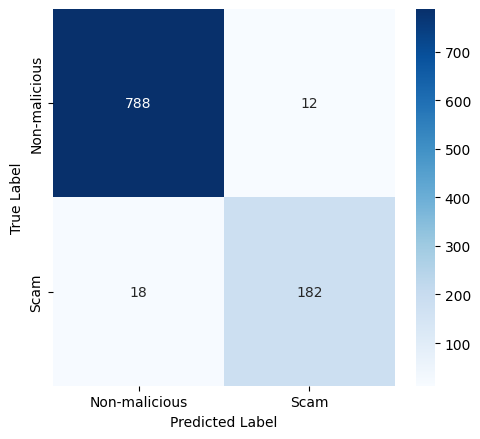

In [135]:
eval_results = eval_model(true_labels, predicted_labels)
print_eval(eval_results)
plot_confusion_matrix(true_labels, predicted_labels)

### 2.2 Out-of-Vocabulary (OOV) Words

In [105]:
oov_messages = 0
skipped_messages = 0

for text in test_texts:
    tokens = text.split()
    tokens_in_vocab = [token for token in tokens if token in vocabulary]
    if not tokens_in_vocab:
        skipped_messages += 1
    elif len(tokens) != len(tokens_in_vocab):
        oov_messages += 1

print(f"OOV Messages (some tokens missing): {oov_messages}")
print(f"Skipped Messages (no tokens in vocab): {skipped_messages}")

OOV Messages (some tokens missing): 142
Skipped Messages (no tokens in vocab): 0


### 2.3 Examples of High and Low Confidence

In [107]:
test_df['prediction'] = predicted_labels
test_df['confidence_ratio'] = confidence_ratios

# print("--- High Confidence Scam Predictions ---")
# high_conf_scam = test_df[test_df['prediction'] == 1].sort_values(by='confidence_ratio', ascending=False).head(3)
# print(high_conf_scam[['textPreprocessed', 'confidence_ratio']])

# print("\n--- High Confidence Non-Malicious Predictions ---")
# high_conf_nonmal = test_df[test_df['prediction'] == 0].sort_values(by='confidence_ratio', ascending=True).head(5)
# print(high_conf_nonmal[['textPreprocessed', 'confidence_ratio']])

# print("\n--- Boundary Cases (Confidence Ratio ≈ 1) ---")
# boundary = test_df[(test_df['confidence_ratio'] > 0.9) & (test_df['confidence_ratio'] < 1.1)].head(3)
# print(boundary[['textPreprocessed', 'confidence_ratio']])

## 3. Extending the model with semi-supervised training

## 4. Supervised model evaluation